<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/TorchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File path: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/TorchCNN.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [77]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!





In [0]:
def to_one_hot(x):
    b = np.zeros((len(x), 10))
    b[np.arange(len(x)), x] = 1
    return b

In [79]:
x_test = []
y_test = []

for data in test_loader:
    x_test.append(data[0].reshape(1, 28, 28).numpy())
    y_test.append(data[1][0])

y_test = torch.Tensor(to_one_hot(y_test))
x_test = torch.Tensor(x_test)

In [0]:
x_train = []
y_train = []

for data in test_loader:
    x_train.append(data[0].reshape(1, 28, 28).numpy())
    y_train.append(data[1][0])

y_train = torch.Tensor(to_one_hot(y_train))
x_train = torch.Tensor(x_train)

In [0]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]

In [82]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(torch.min(x_test))
print(torch.max(x_test))

torch.Size([5000, 1, 28, 28]) torch.Size([500, 1, 28, 28]) torch.Size([5000, 10]) torch.Size([500, 10])
tensor(0.)
tensor(1.)


In [0]:
def plot_image(x):
    plt.imshow(x.reshape((28, 28)), cmap='gray')
    # plt.show()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


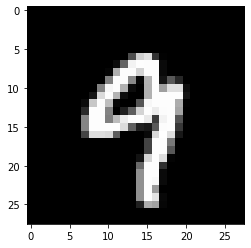

In [84]:
index = 12
plot_image(x_test[index].numpy())
print(y_test[index])
plt.show()

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

Params:
```yaml
input: (b, 1, 28, 28)

conv1:
    input: (b, 1, 28, 28)
    kernel_size: (3, 3)
    weights: (128, 3, 3)
    biases: 128
    stride: 1
    padding: 1
    output: (b, 128, 28, 28)
    activation: relu

conv2:
    input: (b, 128, 28, 28)
    kernel_size: (3, 3)
    weights: (256, 3, 3)
    biases: 256
    stride: 2
    padding: 1
    output: (b, 256, 14, 14)
    activation: relu

conv3:
    input: (b, 256, 14, 14)
    kernel_size: (3, 3)
    weights: (512, 3, 3)
    biases: 512
    stride: 2
    padding: 1
    output: (b, 512, 7, 7)
    activation: relu

fcc1:
    input: (b, 25088)
    weights: (25088, 1000)
    biases: 1000
    output: (b, 1000)
    activation: sigmoid

fcc2:
    input: (b, 1000)
    weights: (1000, 10)
    biases: 10
    output: (b, 10)
    activation: softmax

```

In [0]:
def pad2D(x):
    padded_x = torch.zeros((x.shape[0], x.shape[1], x.shape[2]+2, x.shape[3]+2))
    padded_x[:, :, 1:x.shape[2]+1, 1:x.shape[3]+1] = x
    return padded_x

In [0]:
class Conv2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=False):
        super(Conv2D, self).__init__()
        self.w = get_random((out_channels, in_channels * kernel_size * kernel_size))
        self.b = torch.zeros(out_channels, requires_grad=True)
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x, **kwargs):
        if self.padding:
            x = pad2D(x)
        output = torch.zeros((x.shape[0], self.out_channels, (x.shape[2] - self.kernel_size) // self.stride + 1, (x.shape[3] - self.kernel_size) // self.stride + 1), requires_grad=False)  # (w - k +2p)/s + 1
        row = x.shape[2]
        col = x.shape[3]
        for i in range(0, row - self.kernel_size + 1, self.stride):
            for j in range(0, col - self.kernel_size + 1, self.stride):
                cropped_x = x[:, :, i:i+self.kernel_size, j:j+self.kernel_size]
                h1 = cropped_x.reshape((-1, cropped_x.shape[1] * cropped_x.shape[2] * cropped_x.shape[3])).matmul(self.w.T) + self.b
                output[:, :, i // self.stride, j // self.stride] = h1
        return output

    def optimize(self, lr):
        self.w = (self.w - lr * self.w.grad).detach().requires_grad_()
        self.b = (self.b - lr * self.b.grad).detach().requires_grad_()

In [0]:
class FC(torch.nn.Module):
    def __init__(self, inputs, units):
        super(FC, self).__init__()
        self.w = get_random((inputs, units))
        self.b = torch.zeros(units, requires_grad=True)
        self.units = units
        self.inputs = inputs

    def forward(self, x):
        h1 = x.matmul(self.w) + self.b
        return h1

    def optimize(self, lr):
        self.w = (self.w - lr * self.w.grad).detach().requires_grad_()
        self.b = (self.b - lr * self.b.grad).detach().requires_grad_()

In [0]:
class Classifier (torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = Conv2D(1, 28, 3, 1, True)
        self.fc1 = FC(28 * 28 * 28, 128)
        self.fc2 = FC(128, 10)


    def forward(self, x):
        h1 = torch.relu(self.conv1(x))
        print(h1.shape)
        h1 = h1.reshape(h1.shape[0], -1)  # flatten
        print(h1.shape)
        h2 = torch.sigmoid(self.fc1(h1))
        h3 = torch.nn.functional.softmax(self.fc2(h2))
        return h3

    def optimize(self):
        self.conv1.optimize(0.1)
        self.fc1.optimize(0.1)
        self.fc2.optimize(0.1)

In [0]:
model = Classifier()

In [160]:
index = 133
batch_size = 2

x_sample = x_test[index:index+batch_size]
y_sample = y_test[index:index+batch_size]

y_pred = model(x_sample)
print(f'y_pred: {y_pred}\ny_real: {y_sample}')

loss = torch.nn.functional.binary_cross_entropy(y_pred, y_sample)
loss.backward()

print(loss)

model.optimize()


torch.Size([2, 28, 28, 28])
torch.Size([2, 21952])
y_pred: tensor([[6.5076e-03, 4.9752e-03, 9.2263e-01, 1.0044e-02, 4.0649e-02, 1.5634e-04,
         5.3347e-03, 1.9414e-04, 8.6165e-03, 8.8809e-04],
        [8.4123e-03, 7.9077e-03, 3.3486e-02, 7.0066e-03, 9.2554e-01, 2.1865e-05,
         2.0395e-03, 1.2480e-03, 1.4114e-02, 2.1961e-04]],
       grad_fn=<SoftmaxBackward>)
y_real: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor(0.0156, grad_fn=<BinaryCrossEntropyBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
